In [1]:
import os
import cv2
import glob
import json
import torch
import tifffile
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from classification_datasets import ClassificationDataset, ClassificationTrainDataset ,ClassificationValDataset

In [2]:
cdata = ClassificationDataset(
    root_dir="..\\ICPR02\\kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

Loading dataset into memory...


100%|██████████| 5/5 [02:07<00:00, 25.41s/it]

Found 900 samples with all 12 bands


In [3]:
train_dataset = ClassificationTrainDataset(cdata,200,20,42)
val_dataset = ClassificationValDataset(cdata,20,42)

Augmenting train set for class Blast
Augmenting train set for class Rust


In [4]:
len(train_dataset), len(val_dataset)

(800, 80)

In [5]:
import numpy as np
from torch.utils.data import Subset, DataLoader

def create_balanced_split(dataset, val_samples_per_class=None, max_train_per_class=None):
    """
    Create balanced train/val split with configurable number of samples per class
    
    Args:
        dataset: Your ClassificationDataset
        val_samples_per_class: int or dict mapping class_id to number of val samples
                              If int, same number for all classes
                              If dict, e.g., {0: 20, 1: 15, 2: 25, 3: 20}
        max_train_per_class: int or dict mapping class_id to max training samples
                            If int, same number for all classes
                            If dict, e.g., {0: 100, 1: 80, 2: 120, 3: 100}
    
    Returns:
        train_indices, val_indices
    """
    # Default values
    if val_samples_per_class is None:
        val_samples_per_class = 20
    if max_train_per_class is None:
        max_train_per_class = 100
    
    # Convert to dict if int is provided
    if isinstance(val_samples_per_class, int):
        val_samples_per_class = {0: val_samples_per_class, 1: val_samples_per_class, 
                                 2: val_samples_per_class, 3: val_samples_per_class}
    
    if isinstance(max_train_per_class, int):
        max_train_per_class = {0: max_train_per_class, 1: max_train_per_class, 
                               2: max_train_per_class, 3: max_train_per_class}
    
    # Get all labels
    all_labels = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        all_labels.append(sample['label'])
    
    all_labels = np.array(all_labels)
    
    # Get indices for each class
    class_indices = {
        0: np.where(all_labels == 0)[0],  # RPH
        1: np.where(all_labels == 1)[0],  # Blast
        2: np.where(all_labels == 2)[0],  # Rust
        3: np.where(all_labels == 3)[0],  # Aphid
    }
    
    # Print original class distribution
    print("Original class distribution:")
    class_names = ['RPH', 'Blast', 'Rust', 'Aphid']
    for cls_id, indices in class_indices.items():
        print(f"  {class_names[cls_id]}: {len(indices)} samples")
    
    train_indices = {}
    val_indices = {}
    
    print(f"\nSplitting with custom samples per class:")
    
    # For each class, split into train/val
    for cls_id, indices in class_indices.items():
        # Get the specific counts for this class
        val_count = val_samples_per_class[cls_id]
        train_max = max_train_per_class[cls_id]
        
        # Shuffle indices for this class
        shuffled = indices.copy()
        np.random.shuffle(shuffled)
        
        # Take first val_count for validation
        val_idx = shuffled[:val_count]
        
        # Take next train_max for training
        remaining = shuffled[val_count:]
        train_idx = remaining[:train_max]
        
        # Calculate how many were left out
        left_out = len(remaining) - len(train_idx)
        
        val_indices[cls_id] = val_idx
        train_indices[cls_id] = train_idx
        
        print(f"  {class_names[cls_id]}: {len(train_idx)} train (max: {train_max}), "
              f"{len(val_idx)} val (target: {val_count}), {left_out} left out")
    
    return train_indices, val_indices

# 9 Channels

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_classification_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='satlas_baseline_classification_checkpoints9',
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]),
    minus = 2
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)
    
    # Freeze encoder (optional - remove these lines if you want to fine-tune)
    
    
    # Loss and optimizer
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    
    print(f"Training on {device}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    
    for epoch in range(num_epochs):
        model.train()
        # ================== TRAINING ==================
        # Keep encoder in eval mode if frozen
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            images = batch['c9'].to(device)
            labels = batch['label'] - minus
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in pbar:
                images = batch['c9'].to(device)
                labels = batch['label'] - minus
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_classifier.pth'))
            print(f'  ✓ Saved best model with val_acc = {val_acc:.2f}%')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        print('-' * 60)
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    print(f'\n🎉 Training complete!')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

In [7]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_model(model, dataloader, device='cuda', class_names=['RPH', 'Blast', 'Rust', 'Aphid'], save_path=None,minus = 0):
    """
    Evaluate model and display classification report and confusion matrix
    
    Args:
        model: PyTorch model to evaluate
        dataloader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        class_names: List of class names for display
        save_path: Optional path to save confusion matrix image
    
    Returns:
        dict with predictions, labels, accuracy, and confusion matrix
    """
    model.eval()
    model.to(device)
    
    predictions = []
    ground_truth_labels = []
    
    print("Evaluating model...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            images = batch['c9'].to(device)
            labels = batch['label'].to(device)
            labels = labels - minus
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            ground_truth_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    ground_truth_labels = np.array(ground_truth_labels)
    
    # Calculate overall accuracy
    accuracy = 100. * np.sum(predictions == ground_truth_labels) / len(ground_truth_labels)
    
    # Print classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(ground_truth_labels, predictions, 
                                target_names=class_names, 
                                digits=4))
    
    # Create confusion matrix
    cm = confusion_matrix(ground_truth_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(f'Confusion Matrix\nOverall Accuracy: {accuracy:.2f}%', fontsize=14)
    
    # Add percentage annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            total = cm[i].sum()
            if total > 0:
                percentage = cm[i, j] / total * 100
                plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Total Samples: {len(ground_truth_labels)}")
    print("="*60 + "\n")
    
    return {
        'predictions': predictions,
        'labels': ground_truth_labels,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }


# DataSet Fixing

In [8]:
class SelectiveDataset(Dataset):
    def __init__(self, backing_dataset, labels):
        self.backing_dataset = backing_dataset
        self.samples_by_class = {label: samples for label, samples in backing_dataset.samples_by_class.items() if label in labels}
        self.samples = []
        for _, class_samples in self.samples_by_class.items():
            self.samples.extend(class_samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        c9 = img[(3,2,1,4,5,6,7,10,11),:,:]
        c12 = img[(3,2,1,4,5,6,7,10,11,0,8,9),:,:]
        return {
            'c9': c9,
            'c12': c12,
            'label': label
        }
    
    def __len__(self):
        return len(self.samples)

# RPH BLAST MODEL

In [12]:
train_dataset1 = SelectiveDataset(train_dataset, ['RPH', 'Blast'])
val_dataset1 = SelectiveDataset(val_dataset, ['RPH', 'Blast'])

train_loader1 = DataLoader(
    train_dataset1,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader1 = DataLoader(
    val_dataset1,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader1)}")
print(f"Val batches: {len(val_loader1)}")


DataLoaders created successfully!
Train batches: 25
Val batches: 3


In [13]:
print(len(train_dataset1), len(val_dataset1))

400 40


In [18]:
from satlasswin import SatlasSwin
class ClassificationModel1(nn.Module):
    def __init__(self, encoder_path = None, *args, **kwargs ,):
        super().__init__(*args, **kwargs)
        self.encoder = SatlasSwin(channels=9)

        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.encoder.eval()

        self.stack = nn.Sequential(
                        nn.Conv2d(1024,256,kernel_size=1,stride=1),
                        nn.LeakyReLU(),
                        nn.Flatten(),
                     
                        nn.Linear(256 * 8 * 8,256 * 6),
                        nn.LeakyReLU(),
                        
                        nn.Linear(256 * 6,128 * 3),
                        nn.LeakyReLU(),
                      
                        nn.Linear(128 * 3,64),
                        nn.LeakyReLU(),
                       
                        nn.Linear(64,2),
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x[3]
        return self.stack(x)

Total parameters: 113,987,874
Trainable parameters: 26,044,738
Frozen parameters: 87,943,136
Training on cuda
Total trainable parameters: 26,044,738


Epoch 1/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.20it/s, loss=0.8154, acc=42.50%]



Epoch 1/20:
  Train Loss: 0.7277 | Train Acc: 51.25%
  Val Loss:   0.7427 | Val Acc:   42.50%
  ✓ Saved best model with val_acc = 42.50%
------------------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s, loss=0.8048, acc=47.50%]



Epoch 2/20:
  Train Loss: 0.6943 | Train Acc: 60.25%
  Val Loss:   0.7249 | Val Acc:   47.50%
  ✓ Saved best model with val_acc = 47.50%
------------------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s, loss=0.7872, acc=52.50%]



Epoch 3/20:
  Train Loss: 0.6289 | Train Acc: 65.25%
  Val Loss:   0.7957 | Val Acc:   52.50%
  ✓ Saved best model with val_acc = 52.50%
------------------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s, loss=0.7016, acc=57.50%]



Epoch 4/20:
  Train Loss: 0.5621 | Train Acc: 67.75%
  Val Loss:   0.6993 | Val Acc:   57.50%
  ✓ Saved best model with val_acc = 57.50%
------------------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s, loss=0.7167, acc=50.00%]



Epoch 5/20:
  Train Loss: 0.5864 | Train Acc: 68.75%
  Val Loss:   0.7026 | Val Acc:   50.00%
------------------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s, loss=0.4449, acc=52.50%]



Epoch 6/20:
  Train Loss: 0.5538 | Train Acc: 72.50%
  Val Loss:   0.8034 | Val Acc:   52.50%
------------------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.15it/s, loss=0.5212, acc=57.50%]



Epoch 7/20:
  Train Loss: 0.5767 | Train Acc: 70.50%
  Val Loss:   0.6898 | Val Acc:   57.50%
------------------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s, loss=0.8655, acc=65.00%]



Epoch 8/20:
  Train Loss: 0.5199 | Train Acc: 75.25%
  Val Loss:   0.8354 | Val Acc:   65.00%
  ✓ Saved best model with val_acc = 65.00%
------------------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s, loss=0.4971, acc=65.00%]



Epoch 9/20:
  Train Loss: 0.5028 | Train Acc: 75.50%
  Val Loss:   0.6768 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 10/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s, loss=0.8518, acc=60.00%]



Epoch 10/20:
  Train Loss: 0.4601 | Train Acc: 80.00%
  Val Loss:   0.7389 | Val Acc:   60.00%
------------------------------------------------------------


Epoch 11/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s, loss=0.9561, acc=62.50%]



Epoch 11/20:
  Train Loss: 0.4490 | Train Acc: 80.25%
  Val Loss:   0.7073 | Val Acc:   62.50%
------------------------------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s, loss=1.0644, acc=65.00%]



Epoch 12/20:
  Train Loss: 0.4270 | Train Acc: 82.75%
  Val Loss:   0.7932 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s, loss=0.9292, acc=70.00%]



Epoch 13/20:
  Train Loss: 0.3393 | Train Acc: 85.00%
  Val Loss:   0.8037 | Val Acc:   70.00%
  ✓ Saved best model with val_acc = 70.00%
------------------------------------------------------------


Epoch 14/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s, loss=0.6732, acc=75.00%]



Epoch 14/20:
  Train Loss: 0.2748 | Train Acc: 87.50%
  Val Loss:   0.6401 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s, loss=1.0963, acc=70.00%]



Epoch 15/20:
  Train Loss: 0.2879 | Train Acc: 86.75%
  Val Loss:   0.9883 | Val Acc:   70.00%
------------------------------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s, loss=0.9553, acc=70.00%]



Epoch 16/20:
  Train Loss: 0.3024 | Train Acc: 86.00%
  Val Loss:   0.7111 | Val Acc:   70.00%
------------------------------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.50it/s, loss=1.9207, acc=67.50%]



Epoch 17/20:
  Train Loss: 0.2243 | Train Acc: 92.75%
  Val Loss:   1.1031 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s, loss=0.9776, acc=75.00%]



Epoch 18/20:
  Train Loss: 0.1844 | Train Acc: 93.50%
  Val Loss:   0.7793 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s, loss=1.0488, acc=75.00%]



Epoch 19/20:
  Train Loss: 0.1775 | Train Acc: 93.25%
  Val Loss:   0.7763 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s, loss=1.8997, acc=70.00%]



Epoch 20/20:
  Train Loss: 0.1043 | Train Acc: 96.50%
  Val Loss:   1.0984 | Val Acc:   70.00%
------------------------------------------------------------


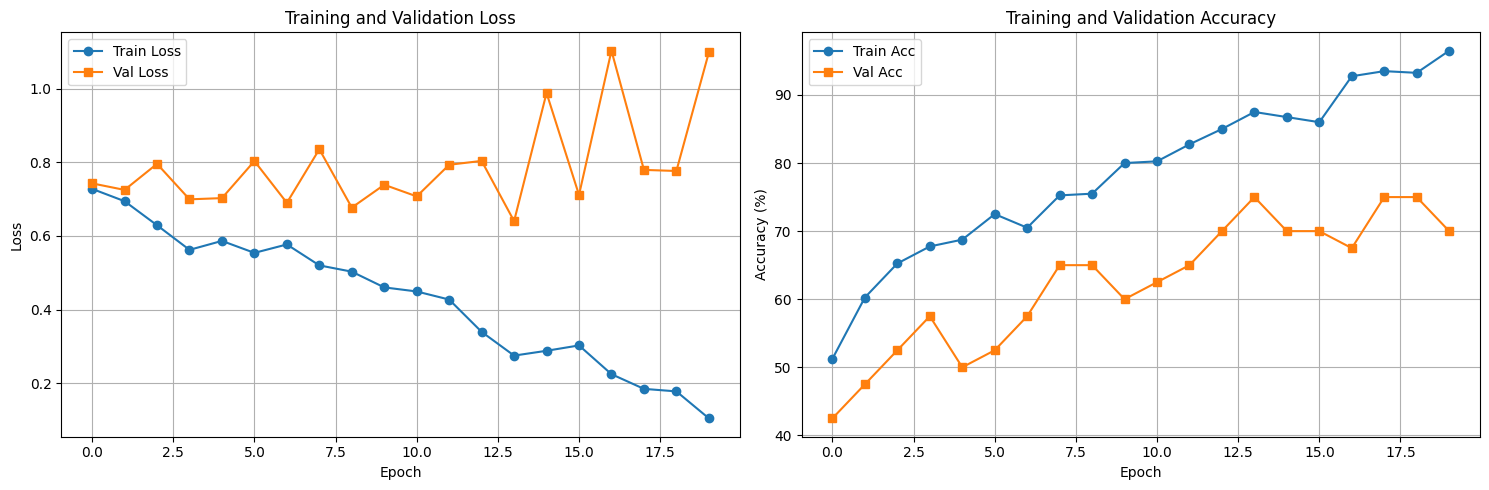


🎉 Training complete!
Best validation accuracy: 75.00%


In [23]:
model1 = ClassificationModel1()

total_params = sum(p.numel() for p in model1.parameters())
trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_classification_model(
    model=model1,
    train_loader=train_loader1,
    val_loader=val_loader1,
    num_epochs=20,
    learning_rate=1e-4 * 5 ,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir="rph_blast_classifier",
    class_weights = torch.tensor([1.0,1.0]),
    minus= 0
)


FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.7778    0.7000    0.7368        20
       Blast     0.7273    0.8000    0.7619        20

    accuracy                         0.7500        40
   macro avg     0.7525    0.7500    0.7494        40
weighted avg     0.7525    0.7500    0.7494        40


✓ Confusion matrix saved to: satlas_baseline_classification_checkpoints9/final_confusion_matrix.png


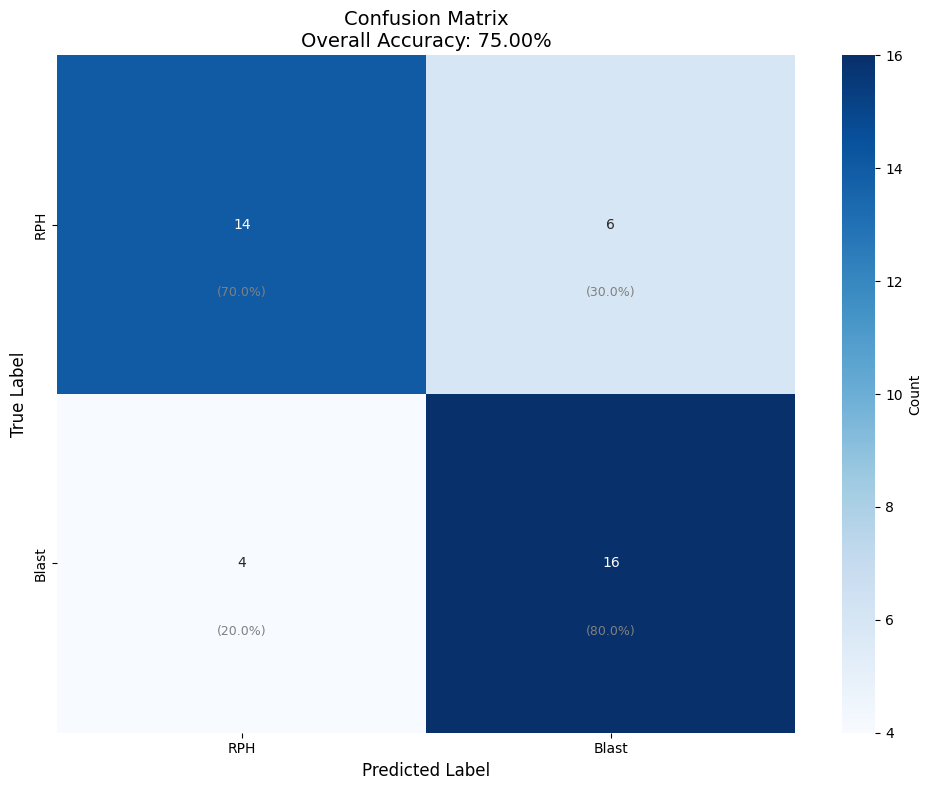


Overall Accuracy: 75.00%
Total Samples: 40



In [24]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ClassificationModel1(None)
best_model.load_state_dict(torch.load("rph_blast_classifier/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader1,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast'],
    save_path='satlas_baseline_classification_checkpoints9/final_confusion_matrix.png'
)


# Rust Aphid MODEL

In [28]:
train_dataset2 = SelectiveDataset(train_dataset, ['Rust', 'Aphid'])
val_dataset2 = SelectiveDataset(val_dataset,['Rust', 'Aphid'])

train_loader2 = DataLoader(
    train_dataset2,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader2 = DataLoader(
    val_dataset2,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader2)}")
print(f"Val batches: {len(val_loader2)}")


DataLoaders created successfully!
Train batches: 25
Val batches: 3


In [19]:
from satlasswin import SatlasSwin
class ClassificationModel2(nn.Module):
    def __init__(self, encoder_path = None, *args, **kwargs ,):
        super().__init__(*args, **kwargs)
        self.encoder = SatlasSwin(channels=9)

        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.encoder.eval()

        self.stack = nn.Sequential(
                        nn.Conv2d(1024,256,kernel_size=1,stride=1),
                        nn.LeakyReLU(),
                        nn.Flatten(),
                        nn.Linear(256 * 8 * 8,256 * 6),
                        nn.LeakyReLU(),
                        nn.Linear(256 * 6,128 * 3),
                        nn.LeakyReLU(),
                        nn.Linear(128 * 3,64),
                        nn.LeakyReLU(),
                        nn.Linear(64,2),
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x[3]
        return self.stack(x)

Total parameters: 113,987,874
Trainable parameters: 26,044,738
Frozen parameters: 87,943,136
Training on cuda
Total trainable parameters: 26,044,738


Epoch 1/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s, loss=0.7627, acc=70.00%]



Epoch 1/20:
  Train Loss: 0.6727 | Train Acc: 53.50%
  Val Loss:   0.6069 | Val Acc:   70.00%
  ✓ Saved best model with val_acc = 70.00%
------------------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s, loss=0.8255, acc=75.00%]



Epoch 2/20:
  Train Loss: 0.4683 | Train Acc: 74.50%
  Val Loss:   0.5142 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s, loss=0.1522, acc=72.50%]



Epoch 3/20:
  Train Loss: 0.3128 | Train Acc: 85.25%
  Val Loss:   0.6165 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s, loss=0.3928, acc=75.00%]



Epoch 4/20:
  Train Loss: 0.3346 | Train Acc: 85.50%
  Val Loss:   0.4879 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.14it/s, loss=0.1374, acc=72.50%]



Epoch 5/20:
  Train Loss: 0.2397 | Train Acc: 87.25%
  Val Loss:   0.6793 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s, loss=0.1429, acc=75.00%]



Epoch 6/20:
  Train Loss: 0.2007 | Train Acc: 91.75%
  Val Loss:   0.5315 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s, loss=0.1002, acc=75.00%]



Epoch 7/20:
  Train Loss: 0.1662 | Train Acc: 92.75%
  Val Loss:   0.6621 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s, loss=0.0312, acc=70.00%]



Epoch 8/20:
  Train Loss: 0.1114 | Train Acc: 95.50%
  Val Loss:   1.1935 | Val Acc:   70.00%
------------------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.24it/s, loss=0.0783, acc=72.50%]



Epoch 9/20:
  Train Loss: 0.1191 | Train Acc: 94.75%
  Val Loss:   0.7464 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 10/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.05it/s, loss=0.1316, acc=80.00%]



Epoch 10/20:
  Train Loss: 0.1553 | Train Acc: 94.25%
  Val Loss:   0.5154 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 11/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s, loss=0.0859, acc=75.00%]



Epoch 11/20:
  Train Loss: 0.1311 | Train Acc: 95.50%
  Val Loss:   0.5507 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s, loss=0.0845, acc=77.50%]



Epoch 12/20:
  Train Loss: 0.1117 | Train Acc: 95.25%
  Val Loss:   0.6067 | Val Acc:   77.50%
------------------------------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s, loss=0.1362, acc=80.00%]



Epoch 13/20:
  Train Loss: 0.0850 | Train Acc: 96.50%
  Val Loss:   0.6062 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 14/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s, loss=0.1167, acc=80.00%]



Epoch 14/20:
  Train Loss: 0.1161 | Train Acc: 95.75%
  Val Loss:   0.5224 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s, loss=0.0627, acc=75.00%]



Epoch 15/20:
  Train Loss: 0.0756 | Train Acc: 97.50%
  Val Loss:   0.6236 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s, loss=0.0517, acc=80.00%]



Epoch 16/20:
  Train Loss: 0.0742 | Train Acc: 96.50%
  Val Loss:   0.5782 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s, loss=0.0561, acc=80.00%]



Epoch 17/20:
  Train Loss: 0.0768 | Train Acc: 97.25%
  Val Loss:   0.5369 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s, loss=0.0274, acc=80.00%]



Epoch 18/20:
  Train Loss: 0.0460 | Train Acc: 99.00%
  Val Loss:   0.6274 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s, loss=0.0197, acc=75.00%]



Epoch 19/20:
  Train Loss: 0.0475 | Train Acc: 97.75%
  Val Loss:   0.7148 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s, loss=0.0554, acc=80.00%]



Epoch 20/20:
  Train Loss: 0.0832 | Train Acc: 97.00%
  Val Loss:   0.6173 | Val Acc:   80.00%
  ✓ Saved best model with val_acc = 80.00%
------------------------------------------------------------


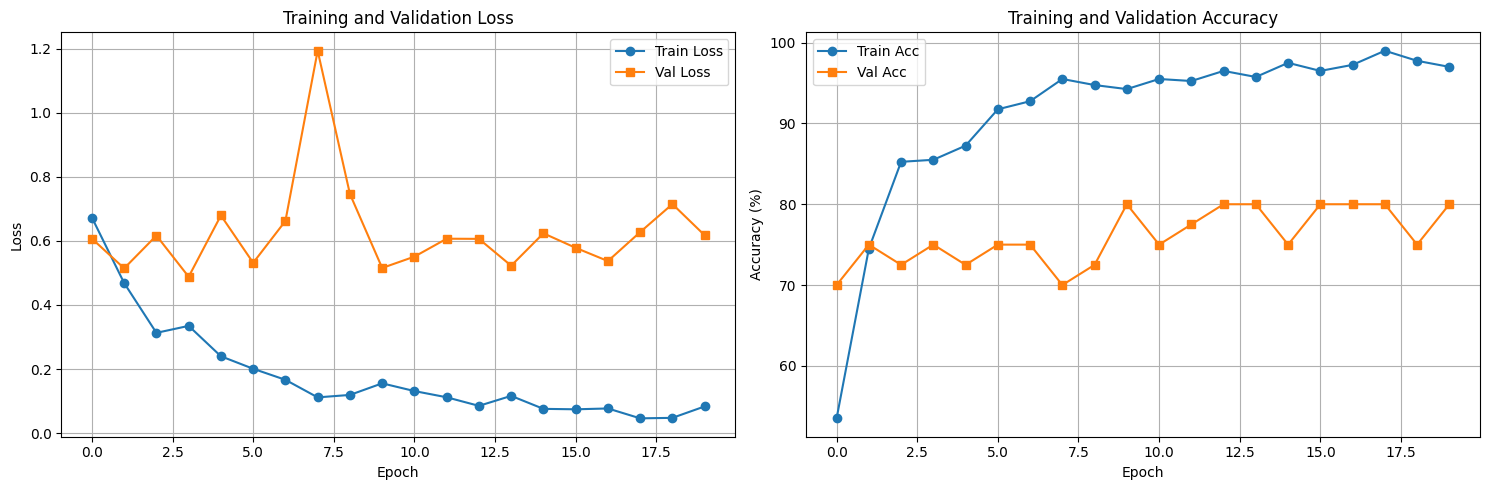


🎉 Training complete!
Best validation accuracy: 80.00%


In [32]:
model2 = ClassificationModel2()

total_params = sum(p.numel() for p in model2.parameters())
trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_classification_model(
    model=model2,
    train_loader=train_loader2,
    val_loader=val_loader2,
    num_epochs=20,
    learning_rate=1e-4 * 2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir="rust_aphid_classifier",
    class_weights = torch.tensor([1.5,1.0]),
    minus=2
)


FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Rust     0.9286    0.6500    0.7647        20
       Aphid     0.7308    0.9500    0.8261        20

    accuracy                         0.8000        40
   macro avg     0.8297    0.8000    0.7954        40
weighted avg     0.8297    0.8000    0.7954        40


✓ Confusion matrix saved to: satlas_baseline_classification_checkpoints9/final_confusion_matrix.png


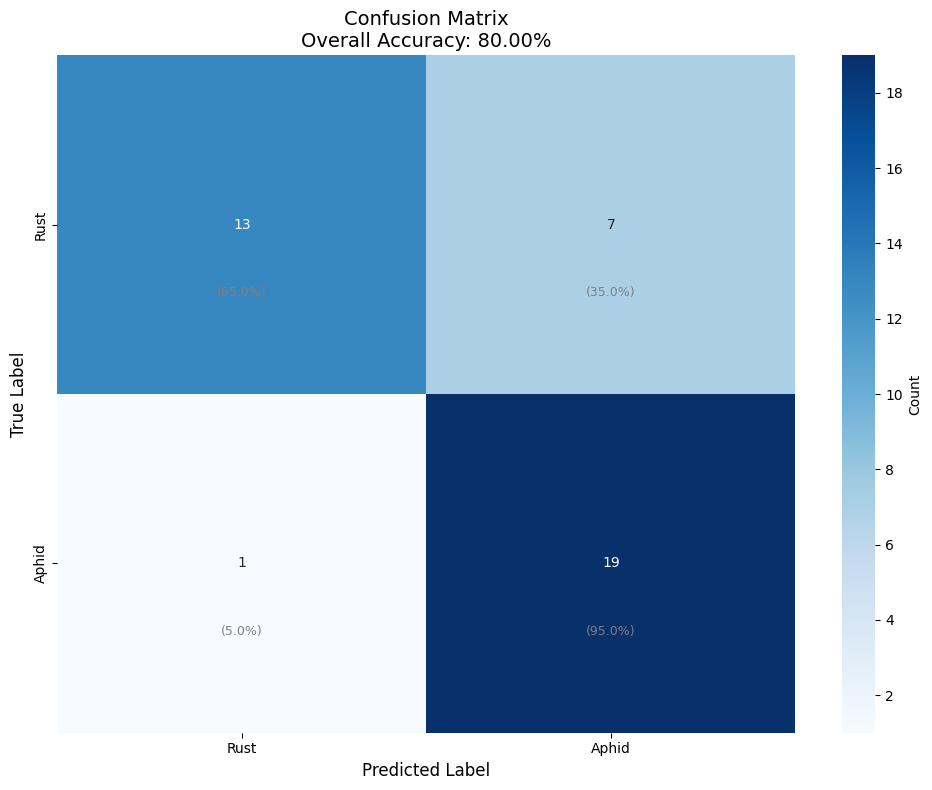


Overall Accuracy: 80.00%
Total Samples: 40



In [33]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ClassificationModel2(None)
best_model.load_state_dict(torch.load("rust_aphid_classifier/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['Rust', 'Aphid'],
    save_path='satlas_baseline_classification_checkpoints9/final_confusion_matrix.png',
    minus=2
)


# Parent

In [23]:
train_dataset2 = SelectiveDataset(train_dataset, ['RPH','Blast','Rust', 'Aphid'])
val_dataset2 = SelectiveDataset(val_dataset,['RPH','Blast','Rust', 'Aphid'])

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


DataLoaders created successfully!
Train batches: 50
Val batches: 5


In [20]:
from satlasswin import SatlasSwin
class ClassificationModel(nn.Module):
    def __init__(self, encoder_path = None, *args, **kwargs ,):
        super().__init__(*args, **kwargs)
        self.encoder = SatlasSwin(channels=9)

        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.encoder.eval()

        self.stack = nn.Sequential(
                        nn.Conv2d(1024,256,kernel_size=1,stride=1),
                        nn.LeakyReLU(),
                        nn.Flatten(),
                        nn.Linear(256 * 8 * 8,256 * 8),
                        nn.LeakyReLU(),
                        nn.Linear(256 * 8,256),
                        nn.LeakyReLU(),
                        nn.Linear(256,64),
                        nn.LeakyReLU(),
                        nn.Linear(64,4),
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x[3]
        return self.stack(x)
    

Total parameters: 122,303,268
Trainable parameters: 34,360,132
Frozen parameters: 87,943,136
Training on cuda
Total trainable parameters: 34,360,132


Epoch 1/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s, loss=0.7077, acc=61.25%]



Epoch 1/20:
  Train Loss: 0.9841 | Train Acc: 53.12%
  Val Loss:   0.7588 | Val Acc:   61.25%
  ✓ Saved best model with val_acc = 61.25%
------------------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s, loss=0.2375, acc=61.25%]



Epoch 2/20:
  Train Loss: 0.7089 | Train Acc: 63.50%
  Val Loss:   0.6920 | Val Acc:   61.25%
  ✓ Saved best model with val_acc = 61.25%
------------------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s, loss=0.4335, acc=66.25%]



Epoch 3/20:
  Train Loss: 0.6833 | Train Acc: 66.38%
  Val Loss:   0.6068 | Val Acc:   66.25%
  ✓ Saved best model with val_acc = 66.25%
------------------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.3402, acc=57.50%]



Epoch 4/20:
  Train Loss: 0.6148 | Train Acc: 71.12%
  Val Loss:   0.8176 | Val Acc:   57.50%
------------------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s, loss=0.1711, acc=58.75%]



Epoch 5/20:
  Train Loss: 0.5531 | Train Acc: 73.75%
  Val Loss:   0.6399 | Val Acc:   58.75%
------------------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.0594, acc=63.75%]



Epoch 6/20:
  Train Loss: 0.4804 | Train Acc: 76.50%
  Val Loss:   0.8149 | Val Acc:   63.75%
------------------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s, loss=0.2909, acc=63.75%]



Epoch 7/20:
  Train Loss: 0.4495 | Train Acc: 79.00%
  Val Loss:   0.7555 | Val Acc:   63.75%
------------------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s, loss=0.1401, acc=65.00%]



Epoch 8/20:
  Train Loss: 0.3577 | Train Acc: 84.38%
  Val Loss:   0.9381 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s, loss=0.1249, acc=68.75%]



Epoch 9/20:
  Train Loss: 0.3694 | Train Acc: 83.50%
  Val Loss:   0.8100 | Val Acc:   68.75%
  ✓ Saved best model with val_acc = 68.75%
------------------------------------------------------------


Epoch 10/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, loss=0.2500, acc=63.75%]



Epoch 10/20:
  Train Loss: 0.3249 | Train Acc: 86.25%
  Val Loss:   0.9831 | Val Acc:   63.75%
------------------------------------------------------------


Epoch 11/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.31it/s, loss=0.1974, acc=75.00%]



Epoch 11/20:
  Train Loss: 0.2920 | Train Acc: 87.38%
  Val Loss:   0.7786 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.1536, acc=67.50%]



Epoch 12/20:
  Train Loss: 0.2818 | Train Acc: 88.38%
  Val Loss:   1.0073 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s, loss=0.2654, acc=71.25%]



Epoch 13/20:
  Train Loss: 0.3006 | Train Acc: 87.12%
  Val Loss:   0.8241 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 14/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s, loss=0.3102, acc=65.00%]



Epoch 14/20:
  Train Loss: 0.2337 | Train Acc: 89.50%
  Val Loss:   1.0857 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.0958, acc=70.00%]



Epoch 15/20:
  Train Loss: 0.2112 | Train Acc: 92.62%
  Val Loss:   0.9257 | Val Acc:   70.00%
------------------------------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=0.0837, acc=75.00%]



Epoch 16/20:
  Train Loss: 0.1416 | Train Acc: 94.88%
  Val Loss:   0.9070 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s, loss=0.1728, acc=72.50%]



Epoch 17/20:
  Train Loss: 0.1788 | Train Acc: 93.50%
  Val Loss:   0.8838 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.1581, acc=71.25%]



Epoch 18/20:
  Train Loss: 0.1765 | Train Acc: 92.88%
  Val Loss:   0.9476 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, loss=0.0934, acc=71.25%]



Epoch 19/20:
  Train Loss: 0.1292 | Train Acc: 95.62%
  Val Loss:   1.0268 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s, loss=0.1038, acc=70.00%]



Epoch 20/20:
  Train Loss: 0.0924 | Train Acc: 96.88%
  Val Loss:   1.1090 | Val Acc:   70.00%
------------------------------------------------------------


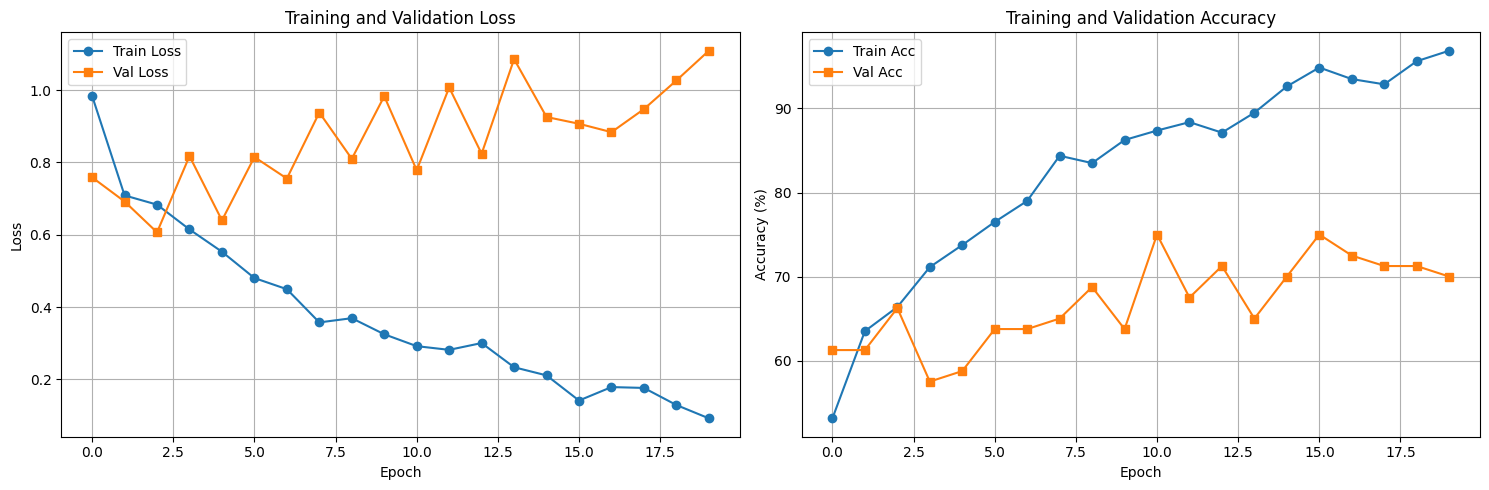


🎉 Training complete!
Best validation accuracy: 75.00%


In [11]:
model = ClassificationModel()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_classification_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    learning_rate=1e-4 * 5,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    minus=0
)


FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.6667    0.7000    0.6829        20
       Blast     0.7368    0.7000    0.7179        20
        Rust     1.0000    0.6500    0.7879        20
       Aphid     0.7037    0.9500    0.8085        20

    accuracy                         0.7500        80
   macro avg     0.7768    0.7500    0.7493        80
weighted avg     0.7768    0.7500    0.7493        80


✓ Confusion matrix saved to: satlas_baseline_classification_checkpoints9/final_confusion_matrix.png


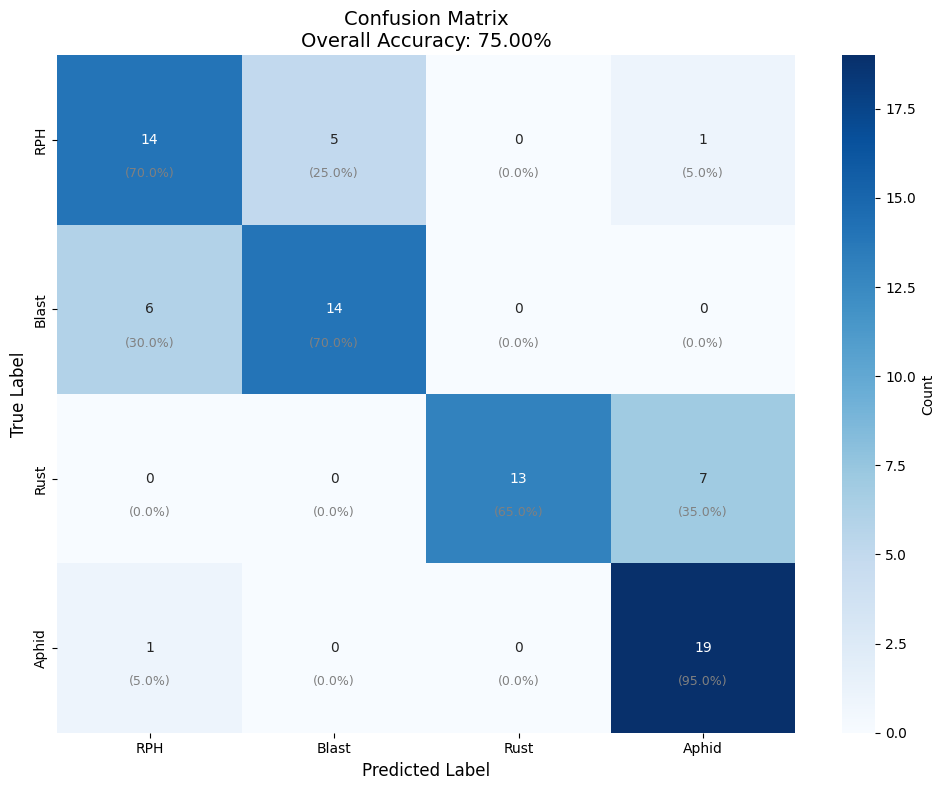


Overall Accuracy: 75.00%
Total Samples: 80



In [12]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ClassificationModel(None)
best_model.load_state_dict(torch.load("satlas_baseline_classification_checkpoints9/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='satlas_baseline_classification_checkpoints9/final_confusion_matrix.png'
)


# ENSEMBLE MODEL

In [22]:
train_datasete = SelectiveDataset(train_dataset, ['RPH','Blast','Rust', 'Aphid'])
val_datasete = SelectiveDataset(val_dataset,['RPH','Blast','Rust', 'Aphid'])

# Create dataloaders
train_loadere = DataLoader(
    train_datasete,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

val_loadere = DataLoader(
    val_datasete,
    batch_size=8,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loadere)}")
print(f"Val batches: {len(val_loadere)}")


DataLoaders created successfully!
Train batches: 100
Val batches: 10


In [16]:
class ensemble3model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.div = ClassificationModel(None)
        self.div.load_state_dict(torch.load("satlas_baseline_classification_checkpoints9/best_classifier.pth")["model_state_dict"])

        self.m1 = ClassificationModel1(None)
        self.m1.load_state_dict(torch.load("rph_blast_classifier/best_classifier.pth")["model_state_dict"])
        self.m1l = nn.Linear(4,2)

        self.m2 = ClassificationModel2(None)
        self.m2.load_state_dict(torch.load("rust_aphid_classifier/best_classifier.pth")["model_state_dict"])
        self.m2l = nn.Linear(4,2)

        self.softmax = nn.Softmax()


    def forward(self, img):
        batch_size = img.size(0)

        # Get predictions from the division model
        x = self.div(img)
        # x = self.softmax(x)

        # Determine which samples go to which model
        # mask is True where x[0] + x[1] > x[2] + x[3]
        mask = (x[:, 0] + x[:, 1]) > (x[:, 2] + x[:, 3])

        # Initialize output tensor
        output = torch.zeros(batch_size, 4, device=img.device, dtype=x.dtype)

        # Process samples that go to model 1
        if mask.any():
            indices_m1 = mask.nonzero(as_tuple=True)[0]
            y1 = self.m1(img[indices_m1])
            

            # Combine features for m1l
            combined_m1 = torch.cat([
                x[indices_m1, :2],  # x[0], x[1]
                y1[:, :2]            # y[0], y[1]
            ], dim=1)

            o1 = self.m1l(combined_m1)
            o1 = self.softmax(o1)
            output[indices_m1, :2] = o1

        # Process samples that go to model 2
        if (~mask).any():
            indices_m2 = (~mask).nonzero(as_tuple=True)[0]
            y2 = self.m2(img[indices_m2])
           

            # Combine features for m2l
            combined_m2 = torch.cat([
                x[indices_m2, 2:],  # x[2], x[3]
                y2[:, :2]            # y[0], y[1]
            ], dim=1)

            o2 = self.m2l(combined_m2)
            o2 = self.softmax(o2)
            output[indices_m2, 2:] = o2

        return output

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_ensemble_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='satlas_ensemble_classification_checkpoints9',
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]),
    minus = 2
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)    
    
    # Loss and optimizer
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    # Tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    
    print(f"Training on {device}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    model.train()
    for epoch in range(num_epochs):
        # ================== TRAINING ==================
        # Keep encoder in eval mode if frozen
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            images = batch['c9'].to(device)
            labels = batch['label'] - minus
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in pbar:
                images = batch['c9'].to(device)
                labels = batch['label'] - minus
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_classifier.pth'))
            print(f'  ✓ Saved best model with val_acc = {val_acc:.2f}%')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        print('-' * 60)
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    print(f'\n🎉 Training complete!')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

In [15]:
modele = ensemble3model()

for param in modele.div.parameters():
        param.requires_grad = False

for param in modele.m1.parameters():
        param.requires_grad = False

for param in modele.m2.parameters():
        param.requires_grad = False

modele.div.eval()
modele.m1.eval()
modele.m2.eval()

total_params = sum(p.numel() for p in modele.parameters())
trainable_params = sum(p.numel() for p in modele.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_ensemble_model(
    model=modele,
    train_loader=train_loadere,
    val_loader=val_loadere,
    num_epochs=20,
    learning_rate=1e-3 * 5,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    minus=0
)

NameError: name 'ensemble3model' is not defined


FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.7143    0.7500    0.7317        20
       Blast     0.7778    0.7000    0.7368        20
        Rust     1.0000    0.6500    0.7879        20
       Aphid     0.7143    1.0000    0.8333        20

    accuracy                         0.7750        80
   macro avg     0.8016    0.7750    0.7724        80
weighted avg     0.8016    0.7750    0.7724        80


✓ Confusion matrix saved to: satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png


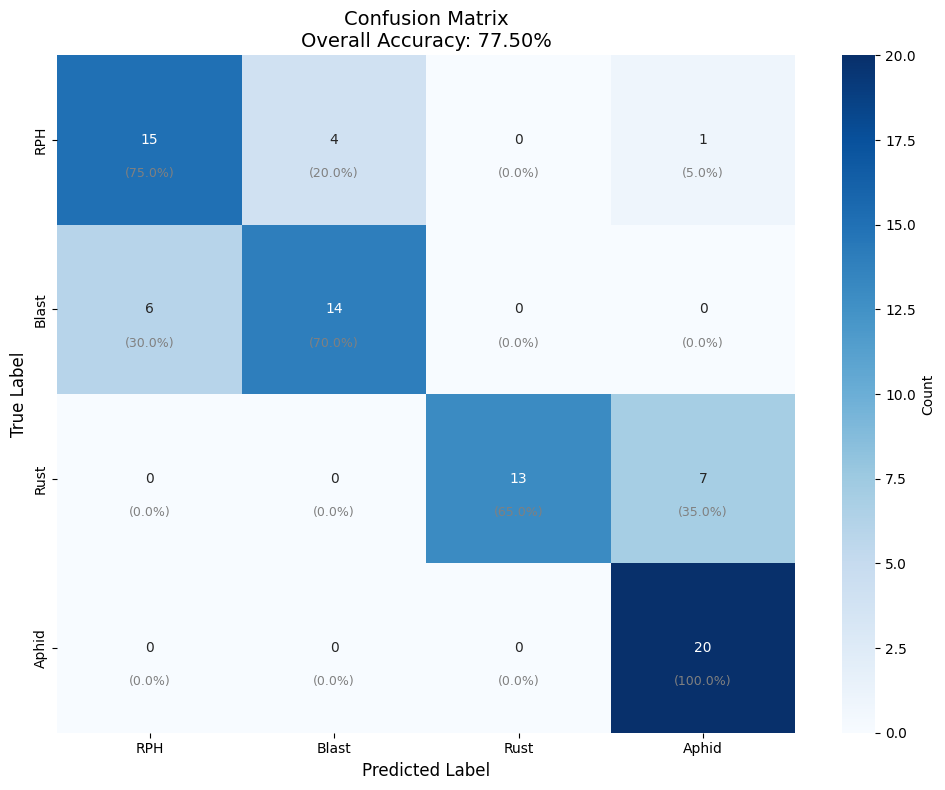


Overall Accuracy: 77.50%
Total Samples: 80



In [26]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ensemble3model()
best_model.load_state_dict(torch.load("satlas_ensemble_classification_checkpoints9/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png'
)

# Ensemble if else

In [34]:
class ensemble3model_ifelse(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.div = ClassificationModel(None)
        self.div.load_state_dict(torch.load("satlas_baseline_classification_checkpoints9/best_classifier.pth")["model_state_dict"])

        self.m1 = ClassificationModel1(None)
        self.m1.load_state_dict(torch.load("rph_blast_classifier/best_classifier.pth")["model_state_dict"])
        self.m1l = nn.Linear(4,2)

        self.m2 = ClassificationModel2(None)
        self.m2.load_state_dict(torch.load("rust_aphid_classifier/best_classifier.pth")["model_state_dict"])
        self.m2l = nn.Linear(4,2)

        self.softmax = nn.Softmax()


    def forward(self, img):
        batch_size = img.size(0)

        # Get predictions from the division model
        x = self.div(img)
        # x = self.softmax(x)

        # Determine which samples go to which model
        # mask is True where x[0] + x[1] > x[2] + x[3]
        mask = (x[:, 0] + x[:, 1]) > (x[:, 2] + x[:, 3])

        # Initialize output tensor
        output = torch.zeros(batch_size, 4, device=img.device, dtype=x.dtype)

        # Process samples that go to model 1
        if mask.any():
            indices_m1 = mask.nonzero(as_tuple=True)[0]
            y1 = self.m1(img[indices_m1])
            y1 = self.softmax(y1)
        
            output[indices_m1, :2] = y1

        # Process samples that go to model 2
        if (~mask).any():
            indices_m2 = (~mask).nonzero(as_tuple=True)[0]
            y2 = self.m2(img[indices_m2])
            y2 = self.softmax(y2)

            output[indices_m2, 2:] = y2

        return output


FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.7647    0.6500    0.7027        20
       Blast     0.7273    0.8000    0.7619        20
        Rust     0.9286    0.6500    0.7647        20
       Aphid     0.7037    0.9500    0.8085        20

    accuracy                         0.7625        80
   macro avg     0.7811    0.7625    0.7595        80
weighted avg     0.7811    0.7625    0.7595        80


✓ Confusion matrix saved to: satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png


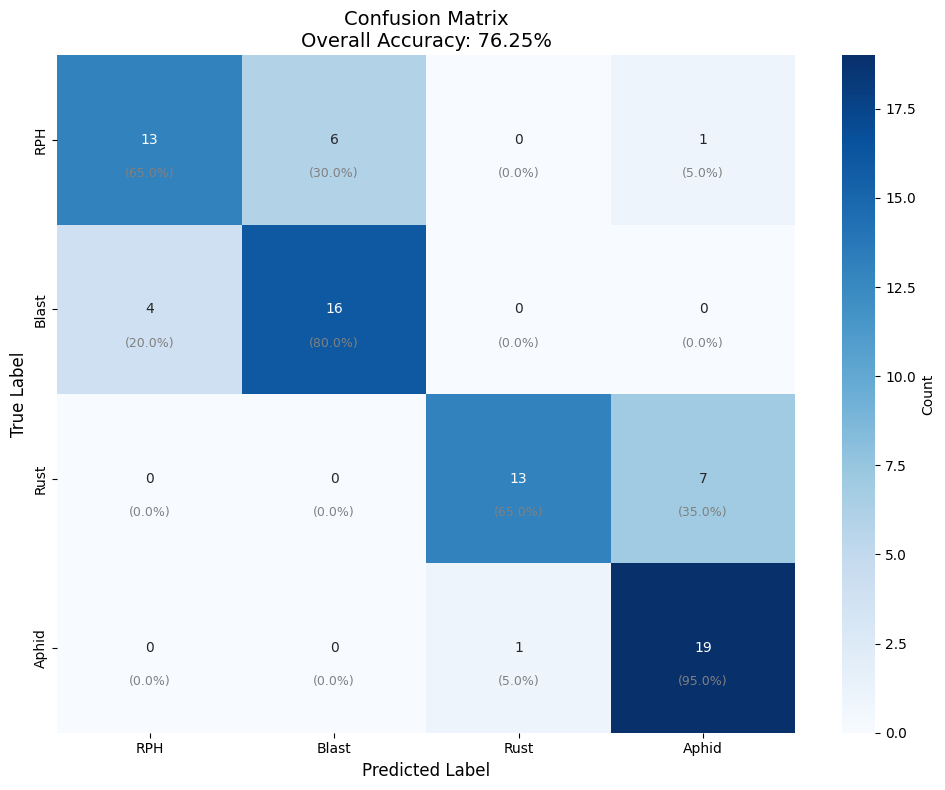


Overall Accuracy: 76.25%
Total Samples: 80



In [35]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ensemble3model_ifelse()

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png'
)


FINAL EVALUATION ON OLD ENSEMBLE
Evaluating model...


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.8947    0.8500    0.8718        20
       Blast     0.9048    0.9500    0.9268        20
        Rust     1.0000    0.9000    0.9474        20
       Aphid     0.9091    1.0000    0.9524        20

    accuracy                         0.9250        80
   macro avg     0.9271    0.9250    0.9246        80
weighted avg     0.9271    0.9250    0.9246        80


✓ Confusion matrix saved to: satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png


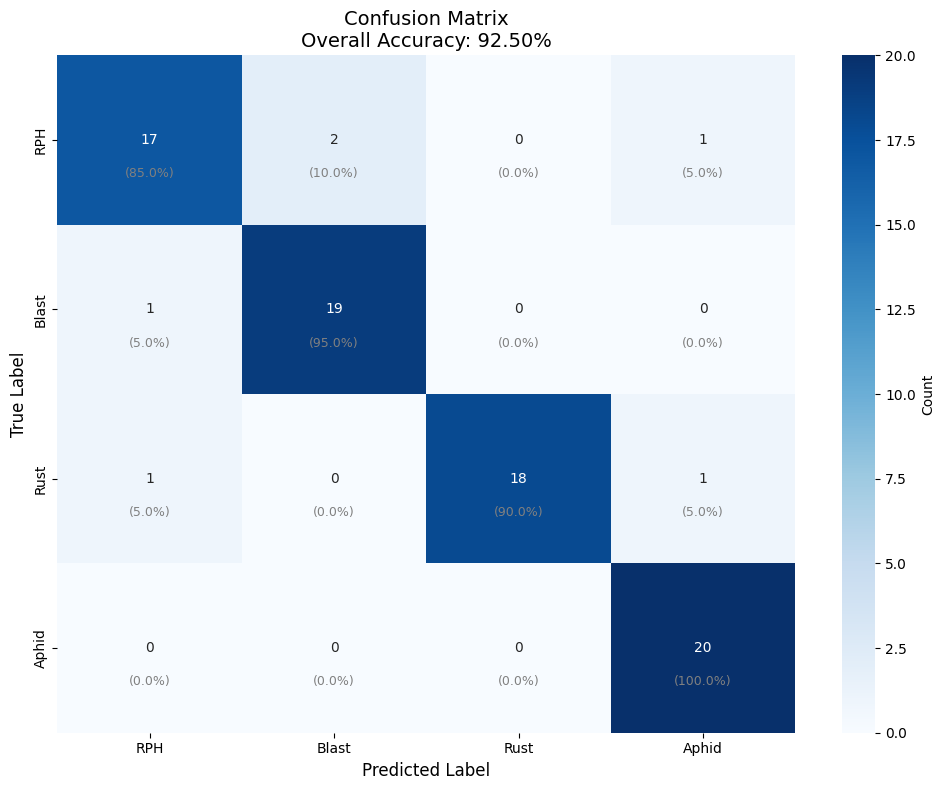


Overall Accuracy: 92.50%
Total Samples: 80



In [25]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON OLD ENSEMBLE")
print("="*60)

best_model = ensemble3model()
best_model.load_state_dict(torch.load("satlas_ensemble_classification_checkpoints9/old_good.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='satlas_ensemble_classification_checkpoints9/final_confusion_matrix.png'
)

# Submission Ensemble

In [27]:
import sys
import torch
sys.path.append('../')
from eval import EvalDataset

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_eval = EvalDataset("..\\ICPR02\\kaggle",target_size=(256, 256))
modele = ensemble3model().to(device)
modele.load_state_dict(torch.load("satlas_ensemble_classification_checkpoints9/old_good.pth")["model_state_dict"])

with torch.no_grad():
    outputs = []
    for i in range(len(data_eval)):
        input = (torch.from_numpy(data_eval.__getitem__(i)['c9']).to(device)).unsqueeze(0)
        outputs.append(torch.argmax(modele(input)).item())
    

Found 40 samples with all 12 bands


c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [29]:
data_eval.write_csv(outputs,".")

Writing submission to .\submission.csv...
Successfully wrote 40 predictions.


# Submission Ensemble if else

In [43]:
import sys
import torch
sys.path.append('../')
from eval import EvalDataset

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_eval = EvalDataset("..\\ICPR02\\kaggle",target_size=(256, 256))
modele = ensemble3model_ifelse().to(device)

with torch.no_grad():
    outputs = []
    for i in range(len(data_eval)):
        input = (torch.from_numpy(data_eval.__getitem__(i)['c9']).to(device)).unsqueeze(0)
        outputs.append(torch.argmax(modele(input)).item())
    

Found 40 samples with all 12 bands


In [45]:
data_eval.write_csv(outputs,".")

Writing submission to .\submission.csv...
Successfully wrote 40 predictions.
